# Large Language Model Tutor for Global Minority Languages

## Introduction

### Problem Description

The recent success of Large Language Models (LLMs) has driven a great deal of interest in applications ranging from homework help to global domination.

One of the most exciting possibilities for LLMs is their application to problems of knowledge accessibility.

Companies like DuoLingo and Khan Academy are leveraging LLMs and other forms of machine learning to provide a replacement for a human tutor. However, there is a dearth of learning resources available for global minority languages, that is, languages that are not among the languages most widely spoken.

One such language is Nepali. Nepali is spoken natively by 16 million people and is used as a second language by an additional 9 million, yet it is rarely available as an option for machine translation and LLMs do not cater to its speakers.

However, before effective tools can be made for the Nepali speaking population, it must also be possible for engineers and data scientists to learn Nepali.

### Project Description

In this project I will endeavor to create an AI Nepali tutor. The tutor should be able to understand English language sentences from its student and provide Nepali translations of those sentences. Additionally, it should be able to generate novel sentences in English and provide Nepali translations of those sentences.

Further, Nepali uses the Devanagari script: a form of writing unfamiliar to many English speakers, especially in the west. Thus, the student should be able to provide an unfamiliar sentence in Nepali, written in this script, and receive a translation from the tutor.

For this project I will train a series of models. The first will translate English sentences to Nepali. The second will translate written Nepali into written English. Finally, the third will generate novel sentences in English.

This project presents a unique challenge. There is very little high-quality data available for training on the Nepali language. As such, I've put significant effort into optimizing my models to be as effective as possible with with very little data.

A github repo for this project can be found here:

https://github.com/billingsmoore/nepali-tutor

Note: Your computer may have trouble rendering the Devanagari script resulting in blanks where Nepali sentences should be. Viewing this notebook as a PDF should resolve that issue.

## English to Nepali Translation

First, I will create a model to translate English sentences into Nepali sentences. To create this model, I drew on the Keras tutorial provided here:

https://keras.io/examples/nlp/neural_machine_translation_with_keras_nlp/

I've adapted the model from the tutorial to translate English into Nepali, rather than Spanish, and streamlined the code for simplicity and to meet my need for computational efficiency. Additionally, I've substantially altered the model in order to more fully optimize for the much, much smaller dataset available for the Nepali language.

The first step of this process is to import the necessary libraries.

### Setup

In [116]:
import pathlib
import random
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import matplotlib.pyplot as plt

Next, I will establish the necessary constants for the model. 

I will use a batch size of 4 for my data. This an EXTREMELY small batch size. I'm using such a small batch size in hopes of it helping to account for the extreme smallness of my dataset. This will lead to slower convergence. However, with a larger number of epochs and a careful choice of optimization algorithms (to be discussed later) we can get away with it.

I will train the model for 100 epochs. I had initially hoped to get away with fewer, however, with such small batch sizes, convergence takes longer.

I also establish a size for the vocabulary that the model will use and the dimensions for the model to expect from the data. 

An interesting addition here is AUTOTUNE. tf.data.AUTOTUNE will automate optimization for training the model. This is extremely useful both for effectively utilizing computing resources, and for avoiding too much time lost to optimization tinkering.

In [3]:
BATCH_SIZE = 4
EPOCHS = 100
MAX_SEQUENCE_LENGTH = 40
VOCAB_SIZE = 15000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

AUTOTUNE = tf.data.AUTOTUNE

### Importing and Exploring the Data

Now I will import the dataset that this model will be trained on. This data comes from Anki, a free, open-source flashcard program that is popular with language learners. It is available from this link:

https://www.manythings.org/anki/

I've then split the sentence pairs into two sets and set every English letter to be lowercase to avoid any confusion in the model. This is not necessary for Nepali because the Devanagari script does not use upper and lower cases.

In [4]:
text_file = pathlib.Path('datasets/npi-eng/npi.txt')

with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, nep = line.split("\t")[:2]
    eng = eng.lower()
    text_pairs.append((eng, nep))

The data comes in the form of numerous sentence pairs. First the sentence is given in English, then in Nepali. Each pair also has a source attribution, but that won't be necessary for the model. Below, I've printed some representative sentence pairs.

In [5]:
for _ in range(5):
    print(random.choice(text_pairs))

('there are always exceptions.', 'त्यहाँ सधैं अपवादहरू छन्।')
('tom was killed in 2013.', 'टमको हत्या सन् २०१३ मा भएको थियो ।')
('we are classmates.', 'हामी सहपाठी हौं।')
('let tom do whatever he wants to do.', 'टमले जे गर्न चाहन्छ त्यो गर्न दिनुहोस्।')
('tom was quicker than mary.', 'टम मेरी भन्दा छिटो थियो।')


Now, we can split the sentence pairs into training, validation, and test sets. Notice that this dataset is quite small. This is one of the challenges of creating models for global minority languages. There is substantially less data to work with than if we were working with, for example, Spanish or French. As a result, I've allocated just 5% of the pairs to validation and testing respectively.

In [6]:
random.shuffle(text_pairs)
num_val_samples = int(0.05 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

1574 total pairs
1418 training pairs
78 validation pairs
78 test pairs


### Creating the Tokenizer

The tokenizer will assign each unique word in the dataset a 'token' a unique number that allows the data to be treated numerically during model training. In order to do this, a "vocabulary" must first be created. This is a complete list of the unique English and Nepali words in the dataset.

#### Vocabulary

In [7]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )

    return vocab

#### Tokenizing

Note that I've set aside some peculiar tokens. These correspond to whitespace,unknown characters, the beginnings and endings of sentences. I don't want the tokenizer to treat these things as words that need to be tokenized.

In [8]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = [text_pair[0] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, VOCAB_SIZE, reserved_tokens)

nep_samples = [text_pair[1] for text_pair in train_pairs]
nep_vocab = train_word_piece(nep_samples, VOCAB_SIZE, reserved_tokens)

2023-08-18 10:59:12.371422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-18 10:59:14.363718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-18 10:59:14.364029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Below we can see some example words from the dataset. Note that Nepali uses a distinct writing system that may not render correctly.

In [9]:
print("English Tokens: ", eng_vocab[150:155])
print("Nepali Tokens: ", nep_vocab[200:205])

English Tokens:  ['much', 'old', 're', 'really', '##al']
Nepali Tokens:  ['किन', 'खान', 'तिमीलाई', 'पर्छ', 'भनेर']


Finally, we can tokenize the vocabularies.

In [10]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)

nep_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=nep_vocab, lowercase=False
)

### Data Preprocessing

Next, I will preprocess each batch of data. This consists of re-assembling the English-Nepali sentence pairs. Each sentence must be padded with the "[PAD]" whitespace token in order to make each sequence of tokens the same length. This is because the model expects inputs of a particular shape. Once the sentence has been padded to the appropriate length, a [START] token can be appended to the beginning and an [END] token appended to the end.

Finally, this assembled dataset can be split into training and validation sets.

In [123]:
def eng_nep_preprocess_batch(eng, nep):
    batch_size = tf.shape(nep)[0]

    eng = eng_tokenizer(eng)
    nep = nep_tokenizer(nep)

    # pad eng to max_sequence_length
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value = eng_tokenizer.token_to_id("[PAD]"),
    )

    eng = eng_start_end_packer(eng)

    # add special tokens [start] and [end] and pad nep
    nep_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length = MAX_SEQUENCE_LENGTH + 1,
        start_value = nep_tokenizer.token_to_id("[START]"),
        end_value = nep_tokenizer.token_to_id("[END]"),
        pad_value = nep_tokenizer.token_to_id("[PAD]")
    )

    nep = nep_start_end_packer(nep)

    return (
        {
        "encoder_inputs": eng,
        "decoder_inputs": nep[:, :-1]
        },
        nep[:, 1:],
    )

def make_dataset(pairs):
    eng_texts, nep_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    nep_texts = list(nep_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, nep_texts))
    dataset=dataset.batch(BATCH_SIZE)
    dataset = dataset.map(eng_nep_preprocess_batch, num_parallel_calls=AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

eng_nep_train_ds = make_dataset(train_pairs)
eng_nep_val_ds = make_dataset(val_pairs)

### Creating the Model

Now it's time to build the model itself. This model is an Autoencoder, which consists of an encoder and a decoder. 

The encoder input layer takes in a set of tokenized inputs. These inputs are then passed to a layer that accounts for the number assigned to the token as well as the position of that token in the sentence. The next layer is a typical dense Encoder layer.

The decoder takes in a set of tokenized inputs from the Nepali dataset and passes them to a layer that will account for the token number and position of the token in those sentences. This is then passed to a typical dense Decoder layer.

Both the Encoder and Decoder layers are helpfully provided out-of-the-box by Keras.

In [122]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length = MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim = INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

eng_nep_translator = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="eng_nep_translator",
)

#### Model Summary

In [13]:
eng_nep_translator.summary()

Model: "eng_nep_translator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            3850240   ['encoder_inputs[0][0]']      
 ng (TokenAndPositionEmbedd                                                                       
 ing)                                                                                             
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []           

### Compilation

Now, I've compiled the model.

Of note here is the choice of optimization algorith. I have used RMSProp. RMSProp is similar to Adagrad, which we studied in class, and as a result it converges much more quickly than, say, SGD. However, it is less susceptible to vanishing gradients. This is perfect for our small dataset with small batch sizes.

The loss function is Sparse Categorical Crossentropy. Not every word appears in every sentence so the data for most natural language related tasks is necessarily sparse.

In [125]:
eng_nep_translator.compile(
    "rmsprop", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)

### Fitting the Model

In [126]:
eng_nep_history = eng_nep_translator.fit(
    eng_nep_train_ds, 
    epochs=100, 
    validation_data=eng_nep_val_ds
    )

Epoch 1/100
23/23 [==============================] - 15s 301ms/step - loss: 5.7427 - accuracy: 0.1268 - val_loss: 4.6218 - val_accuracy: 0.2142
Epoch 2/100
23/23 [==============================] - 0s 21ms/step - loss: 4.3512 - accuracy: 0.2179 - val_loss: 4.2112 - val_accuracy: 0.2256
Epoch 3/100
23/23 [==============================] - 1s 24ms/step - loss: 3.9231 - accuracy: 0.2553 - val_loss: 3.8240 - val_accuracy: 0.2549
Epoch 4/100
23/23 [==============================] - 1s 22ms/step - loss: 3.6029 - accuracy: 0.2820 - val_loss: 3.5899 - val_accuracy: 0.2769
Epoch 5/100
23/23 [==============================] - 1s 22ms/step - loss: 3.3899 - accuracy: 0.2981 - val_loss: 3.5028 - val_accuracy: 0.2834
Epoch 6/100
23/23 [==============================] - 1s 22ms/step - loss: 3.2422 - accuracy: 0.3088 - val_loss: 3.4117 - val_accuracy: 0.2818
Epoch 7/100
23/23 [==============================] - 0s 20ms/step - loss: 3.1218 - accuracy: 0.3177 - val_loss: 3.3454 - val_accuracy: 0.2956
Epoc

To avoid training and retraining the model, I'll now save this model with these results.

In [16]:
#eng_nep_translator.save('models/eng-nep-translator.keras')

Now, for future testing, I can reopen the model.

In [17]:
eng_nep_translator = tf.keras.models.load_model('models/eng-nep-translator.keras')

### Visualizing the Training Results

Below, we can see how the loss and accuracy evolved over the course of training. Here we can really see how difficult it is to make effective generative tools from small datasets. Even as the model's accuracy improves substantially on the training set, the accuracy on the validation data remains unacceptably low.

The loss on the validation data also never decreases, instead getting worse as time goes on.

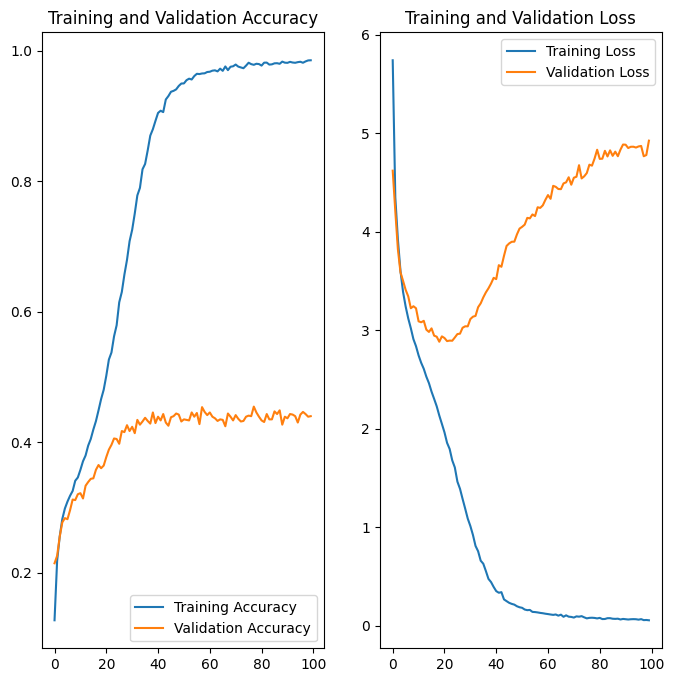

In [127]:
acc = eng_nep_history.history['accuracy']
val_acc = eng_nep_history.history['val_accuracy']

loss = eng_nep_history.history['loss']
val_loss = eng_nep_history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Decoding Translated Sentences

Even if the translations are perfect, the outputs of our model are not meaningful sentences. The model only outputs numerical tokens. In order to turn these into something that a human can read they need to be decoded.

Below is a function to decode these translated sentences. This function takes in an English sentence, runs it through our translator model then works its way through the output of the model, converting the output into words in Nepali using our tokenizers.

Part of decoding the sequence is sampling the probabilities of tokens that should follow the existing translation. The sampler is the algorithm that is used to select that next work or token. Here I've used the Greedy sampler which simply finds the highest likelihood next word and adds it to the translated sentence. It is computationally inexpensive and because the outputs are pretty short we don't need to worry about the Greedy sampler outputting long, repetitive sentences that don't make much sense, which can be an issue with the algorithm.


In [129]:
def eng_nep_translate(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    encoder_input_tokens = eng_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    def next(prompt, cache, index):
        logits = eng_nep_translator([encoder_input_tokens, prompt])[:, index - 1, :]
        hidden_states = None
        return logits, hidden_states, cache
    
    length = 40
    start = tf.fill((batch_size, 1), nep_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, length - 1), nep_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=nep_tokenizer.token_to_id("[END]"),
        index=1
    )
    generated_sentences = nep_tokenizer.detokenize(generated_tokens)
    return generated_sentences

### Example Translations

Now, let's look at some example translations from the model.

In [20]:
test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = eng_nep_translate(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )

    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)
    print()

2023-08-18 10:59:35.830764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-18 10:59:36.980078: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1051b930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-18 10:59:36.980152: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-08-18 10:59:38.690555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-08-18 10:59:40.544634: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-18 10:59:41.517654: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


** Example 0 **
i didn't want to go, but i did.
ी ठ चाहन्छुौं एक अहिलेला ,ब छिन्ौं ड हुँ हुनुहुन्छान थाहाको

** Example 1 **
i know that tom is in bed.
मैलेु दहरूे ौलाई काम थाहाको

** Example 2 **
you won't see me again.
ह मैले ी ा अहिले टमलाई छिन्ो ्ईस थाहा , मैलेलेको

** Example 3 **
when was the last time you cried?
गर्न0 हामी ढसदैनिएको किस हुँै ?

** Example 4 **
i'm pretty sure tom's happy in boston.
मैले ु चाहन्छुरही ढससँगससँगिएको कि थ  एक ठदैन तपाईं दको



## Nepali to English Translation

Now that the English to Nepali Translator is finished, it's time to reverse the process. 

There's no need to repeat the setup stages nor the importing and preprocessing of data, since it can all be reused from the first translator. We can simply refactor our preprocess_batch function to reverse which language is the input and which language is the output.

In [110]:
def nep_eng_preprocess_batch(eng, nep):

    eng = eng_tokenizer(eng)
    nep = nep_tokenizer(nep)

    # pad eng to max_sequence_length
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH+1,
        pad_value = eng_tokenizer.token_to_id("[PAD]"),
    )

    eng = eng_start_end_packer(eng)

    # add special tokens [start] and [end] and pad nep
    nep_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length = MAX_SEQUENCE_LENGTH,
        start_value = nep_tokenizer.token_to_id("[START]"),
        end_value = nep_tokenizer.token_to_id("[END]"),
        pad_value = nep_tokenizer.token_to_id("[PAD]")
    )

    nep = nep_start_end_packer(nep)

    return (
        {
        "encoder_inputs": nep,
        "decoder_inputs": eng[:, :-1]
        },
        eng[:, 1:],
    )

def make_dataset(pairs):
    eng_texts, nep_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    nep_texts = list(nep_texts)
    dataset = tf.data.Dataset.from_tensor_slices((nep_texts, eng_texts))
    dataset=dataset.batch(BATCH_SIZE)
    dataset = dataset.map(nep_eng_preprocess_batch, num_parallel_calls=AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

nep_eng_train_ds = make_dataset(train_pairs)
nep_eng_val_ds = make_dataset(val_pairs)

### Creating the Model

We can reuse the same model architecture from above.

In [111]:
nep_eng_translator = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="nep_eng_translator",
)

#### Model Summary

In [105]:
nep_eng_translator.summary()

Model: "nep_eng_translator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            3850240   ['encoder_inputs[0][0]']      
 ng (TokenAndPositionEmbedd                                                                       
 ing)                                                                                             
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []           

### Compilation

Here I've used the same loss and optimization algorithms as the other translator.

In [112]:
nep_eng_translator.compile(
    "rmsprop", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)

### Fitting the Model

In [113]:
nep_eng_history = nep_eng_translator.fit(
    nep_eng_train_ds, 
    epochs=100, 
    validation_data=nep_eng_val_ds
    )

Epoch 1/100
23/23 [==============================] - 12s 140ms/step - loss: 1.8171 - accuracy: 0.7730 - val_loss: 0.6445 - val_accuracy: 0.7848
Epoch 2/100
23/23 [==============================] - 1s 24ms/step - loss: 0.5696 - accuracy: 0.8187 - val_loss: 0.5252 - val_accuracy: 0.8135
Epoch 3/100
23/23 [==============================] - 1s 22ms/step - loss: 0.4751 - accuracy: 0.8355 - val_loss: 0.4863 - val_accuracy: 0.8463
Epoch 4/100
23/23 [==============================] - 0s 21ms/step - loss: 0.4529 - accuracy: 0.8464 - val_loss: 0.4911 - val_accuracy: 0.8135
Epoch 5/100
23/23 [==============================] - 1s 23ms/step - loss: 0.4292 - accuracy: 0.8491 - val_loss: 0.4543 - val_accuracy: 0.8484
Epoch 6/100
23/23 [==============================] - 0s 20ms/step - loss: 0.4058 - accuracy: 0.8572 - val_loss: 0.4350 - val_accuracy: 0.8525
Epoch 7/100
23/23 [==============================] - 0s 21ms/step - loss: 0.3929 - accuracy: 0.8598 - val_loss: 0.3791 - val_accuracy: 0.8607
Epoc

To avoid training and retraining the model, I'll now save this model with these results.

In [114]:
nep_eng_translator.save('models/nep-eng-translator.keras')

Now, for future testing, I can reopen the model.

In [ ]:
nep_eng_translator = tf.keras.models.load_model('models/nep-eng-translator.keras')

### Visualizing the Training Results

Below we can see a visualization of how loss and accuracy evolved over the course of training. Surprisingly, performance is substantially better in this model!

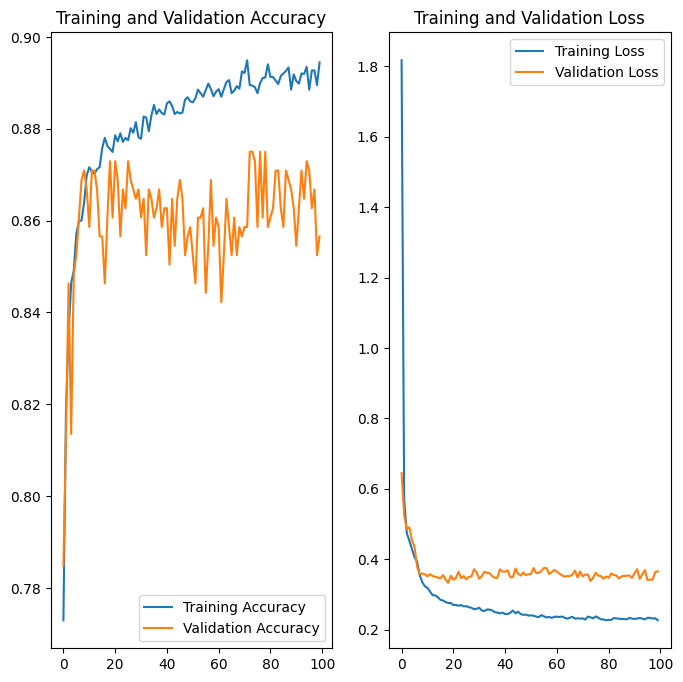

In [118]:
acc = nep_eng_history.history['accuracy']
val_acc = nep_eng_history.history['val_accuracy']

loss = nep_eng_history.history['loss']
val_loss = nep_eng_history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## English Language Text Generator

For the text generator, I will create a mini-GPT model for text generation uses the KerasNLP library. This model will be trained on the simplebooks-92 dataset. This dataset uses a simplified English vocabulary. This is useful both for training purposes and for creating generated output that is readily understandable by individuals who do not speak English as a first language.

To create this model, I drew on the Keras suggested tutorial for text generation that can be found here:

https://keras.io/examples/generative/text_generation_gpt/

### Settings

Below I've selected some key hyperparameters. Particularly notable here is the minimum traing sequence length. This sets the smallest number of tokens that will be examined by the model during training. We want this number to be large enough that the model is not attempting to train on single words or brief phrases which may eat up training time while providing little in the way of performance improvements.

Additionally, NUM_TOKENS_TO_GENERATE decides how many tokens will appear in the output of the model. I've set this value to be relatively low. There are two reasons for this. 

First, in testing, shorter outputs were more likely to be coherent sentences that expressed a single proposition. Given that outputs are meant to be translated and understood, coherence is extremely important. 

Second, because the output sentences are meant to be translated and learned by a student, we want them to be short and simple enough to be readily understood and learned, even by a beginner.

In [85]:
BATCH_SIZE = 64
SEQ_LEN = 128
MIN_TRAINING_SEQ_LEN = 450

EMBED_DIM = 256
FEED_FORWARD_DIM = 256
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 5000

EPOCHS = 50

NUM_CHAR_TO_GENERATE = 50

### Load Simplebooks Data

In [25]:
raw_train_ds = (
    tf.data.TextLineDataset('datasets/simplebooks/simplebooks-92-raw/train.txt')
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

raw_val_ds = (
    tf.data.TextLineDataset("datasets/simplebooks/simplebooks-92-raw/valid.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
)

### Tokenizer for Generator
Here I've defined the vocabulary for the model. This vocabulary is made up of words ('tokens') from the dataset that the model needs to be able to represent and understand.

PAD, UNK, BOS represent padding, unknown, and beginning-of-sentence. These tokens are set aside as non-words for our purposes.

I've then loaded in KerasNLP's tokenizer and used it to preprocess the data for training. This strips out punctuation, sets every word to be all lowercase and then assigns a unique integer to each word. This allows the model to train on the data as quantified data.

Although I've already created a vocabulary and tokenizer for the translator models above, because the set of English sentences in the translation data set is so small, it is necessary to create new ones for the generator model.

Note, if you are re-running this notebook, the vocabulary computation is quite slow.

In [26]:
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    raw_train_ds,
    vocabulary_size = VOCAB_SIZE,
    lowercase = True,
    reserved_tokens = ["[PAD]", "[UNK]", "[BOS]"],
)

In [39]:
gen_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

In [47]:
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=gen_tokenizer.token_to_id("[BOS]")
)

def preprocess(inputs):
    outputs = gen_tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels

train_ds = raw_train_ds.map(tf.autograph.experimental.do_not_convert(preprocess), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

val_ds = raw_val_ds.map(tf.autograph.experimental.do_not_convert(preprocess), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

### Constructing the Model

Now we can actually create the model. This model is another Auto-encoder.

This model is very similar architecturally to the translator model. Tokens are passed to an input layer and then to an embedding layer which accounts for both the number associated with the token as well as the position of the token in its sentential context. This then downsamples the sentence to an embedding.

These embeddings are then passed to a decoder layer that attempts to generate a sentence by upsampling from the embedding.

In [31]:
inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)

embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)

x = embedding_layer(inputs)

for _ in range(NUM_LAYERS):
    decoder_layer = keras_nlp.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)

outputs = keras.layers.Dense(VOCAB_SIZE)(x)
generator = keras.Model(inputs=inputs, outputs=outputs)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Below, I've compiled the model. As before, the loss function is Sparse Categorical Crossentropy. Again, natural language is almost always going to be sparse data so this is the natural choice.

Here I've used Adam as the optimizer. The smallness of the dataset isn't really a concern here so I've chosen Adam for it's ability to produce higher accuracy, even though the computation costs are a little higher.

In [32]:
generator.compile(optimizer='adam', loss=loss_fn, metrics=[])

#### Model Summary

In [33]:
generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 256)         1312768   
 ng_3 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_decoder_3 (Tra  (None, None, 256)         394749    
 nsformerDecoder)                                                
                                                                 
 transformer_decoder_4 (Tra  (None, None, 256)         394749    
 nsformerDecoder)                                                
                                                                 
 dense_16 (Dense)            (None, None, 5000)        1285

### Model Training

Below, I've trained the model. Note that loss is dropping very slowly, which is to say, for a dataset this size the model converges very slowly. For a final product, far more epochs would be needed to achieve satisfactory results.

In [88]:
generator.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/50
   3168/Unknown - 126s 38ms/step - loss: 3.7765

2023-08-18 11:59:29.606552: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 6603943071277581536
2023-08-18 11:59:29.606607: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 4098329605364189913
2023-08-18 11:59:29.606640: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 16341194706631034183


3169/3169 [==============================] - 127s 38ms/step - loss: 3.7765 - val_loss: 3.8371


2023-08-18 11:59:30.314296: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 8472384756783010550
2023-08-18 11:59:30.314341: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 1432970336118965353


Epoch 2/50
3169/3169 [==============================] - 121s 37ms/step - loss: 3.7560 - val_loss: 3.7982
Epoch 3/50
3169/3169 [==============================] - 110s 33ms/step - loss: 3.7386 - val_loss: 3.7830
Epoch 4/50
3169/3169 [==============================] - 107s 33ms/step - loss: 3.7217 - val_loss: 3.8098
Epoch 5/50
3169/3169 [==============================] - 119s 36ms/step - loss: 3.7087 - val_loss: 3.7441
Epoch 6/50
3169/3169 [==============================] - 110s 32ms/step - loss: 3.6967 - val_loss: 3.7557
Epoch 7/50
3169/3169 [==============================] - 102s 31ms/step - loss: 3.6859 - val_loss: 3.7628
Epoch 8/50
3169/3169 [==============================] - 101s 31ms/step - loss: 3.6766 - val_loss: 3.7362
Epoch 9/50
3169/3169 [==============================] - 106s 32ms/step - loss: 3.6688 - val_loss: 3.7375
Epoch 10/50
3169/3169 [==============================] - 108s 33ms/step - loss: 3.6617 - val_loss: 3.7417
Epoch 11/50
3169/3169 [==============================]

Like before, I'll save and reload the model for future testing.

In [89]:
# generator.save('models/text-generator.keras')

In [ ]:
generator = tf.keras.models.load_model('models/text-generator.keras')

### Testing the Text Generator

Let's see what sort of results we're getting from the generator.

Like for the translator models, we need to select a sampler. The sampler is the algorithm used to pick the next work in our output sequence based on the probabilities that were calculated by the model. 

There are a a number of samplers to choose from. I've found the best results, the most coherent sentences, from using the Top P Sampler. 

The Top P Sampler takes a probability, say .9, and selects the most likely sequence of words that sum to that probability. This is different from other samplers which only select the most probable next single word. By using Top P we can get outputs that more closely resemble coherent phrases rather than strings of words that only make sense in context of the couple of words surrounding them.

Below, I've defined a "generate" function which takes in a prompt and returns a sentence generated by our model. Note that the generated outputs need to be cleaned before they are presentable. Like with the translations they are stripped of tokens that simply convey the beginnings and endings of sentences as well as unnecessary whitespace and potentially confusing punctuation.

In [92]:
def generate():
    
    def next(prompt, cache, index):
        logits = generator(prompt)[:, index - 1, :]
        hidden_states = None
        return logits, hidden_states, cache
    
    def clean(txt):
        clean_txt = txt.numpy()[0].decode("utf-8")
        clean_txt = (
        clean_txt.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .replace("[BOS]", "")
        .replace(",", "")
        .replace("!", ".")
        .replace("?", ".")
        .replace("\'", "")
        .replace("\"", "")
        .replace(";", "")
        .replace(":", "")
        )
        clean_txt = clean_txt[:NUM_CHAR_TO_GENERATE].split(".")[0].strip()

        return clean_txt

    prompt = start_packer(gen_tokenizer(['']))
    sampler = keras_nlp.samplers.TopPSampler(p=0.9)
    output_tokens = sampler(
        next=next,
        prompt = prompt,
        index=1,
    )
    txt = clean(gen_tokenizer.detokenize(output_tokens))

    return txt

Ok, now let's pass a prompt to the model and see what we get!

In [93]:
txt = generate()

print(f"Generated text: \n{txt}\n")

Generated text: 
the bulk of a wagon had departed in front of his



## Conclusion

We now have functions that translate from English to Nepali and from Nepali to English. We also have the ability to generate novel sentences in English. Let's take a look again at some examples.

### Example Translations

In [130]:
test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = eng_nep_translate(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )

    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)
    print()

** Example 0 **
no one brought us anything.
तिमिसँग कुनैुख्ने छ ।

** Example 1 **
i didn't want to go, but i did.
मलाई मौैले सक्षध्नेछु ।

** Example 2 **
sharkskin can be used like the skin of other animals.
सुनकको लागि अपष्ट वाद्डा हो ।

** Example 3 **
tom just wanted to be helpful.
टम जसरी चाहन्छु ।

** Example 4 **
this tea is too bitter.
यो अक्बि धेरै राउँदै छ ।



### Text Generation Examples

In [135]:
for i in range(5):
    txt = generate()
    print(f"Generated text {i}: \n{txt}\n")

Generated text 0: 
of course he didn  t want to come out

Generated text 1: 
rhoda and  on the way  the rest of the toys still

Generated text 2: 
i got into the room where i had taken her in my

Generated text 3: 
it is the story of the memmaest  whom you really

Generated text 4: 
look



### Translating Generated Text

Now let's look at translations of generated text.

In [136]:
for i in range(5):
    input_sentence = generate()
    translated = eng_nep_translate(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )

    print(f"** Translation of Generated Text {i} **")
    print(input_sentence)
    print(translated)
    print() 

** Translation of Generated Text 0 **
as time went on their stairs  they made up their
जर्म्रो विदाको राजधानी रोद्याम्दिन मन पर्छ ।

** Translation of Generated Text 1 **
i wish it had to turn to the assault of trodden
मैले के यो शंकाउनुझ्नुभगी ल्याप्त पीचको उठाबीमा हुनुचा घाइते भए ।

** Translation of Generated Text 2 **
several men were very anxious to know all the fac
मलाई स्पष्ट रूपष्ट प्राकुक आगे केही फावना छैन ।

** Translation of Generated Text 3 **
his majesty spoke of his angry words  and was rea
आफ्नो गर्मीमा धेरै रोधैं रात्तिताई दरस्ताता त मारिए वा घाइते भए ।

** Translation of Generated Text 4 **
by daybreak  sir john began to webbergs on the mo
ब्रसेल पुचाउको नजिम्क पवित्रा चाहन्छु ।



So we've done it! This is a great starting place for an AI language tutor. We can translate a into and out of a new language and generate novel sentences for translation and study.

Obviously these models are only a starting point. For a more robust product we will need much more robust data and significantly more training time. This is unfortunately a problem that plagues work on global minority languages. But, hopefully with tools like these we can start to move in the right direction!